In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
dados = pd.read_csv('./data/ibit-usd.csv')[["Date", "Adj Close"]]
dados['Returns'] = np.log(dados['Adj Close']/dados['Adj Close'].shift(1))
dados = dados[['Date', 'Adj Close', 'Returns']].dropna()
dados

,Date,Adj Close,Returns
1,2024-01-12,24.969999,-0.064363
2,2024-01-16,24.719999,-0.010062
3,2024-01-17,24.410000,-0.012620
4,2024-01-18,23.340000,-0.044824
5,2024-01-19,23.799999,0.019517
...,...,...,...
215,2024-11-18,52.130001,0.000000
216,2024-11-19,52.700001,0.010875
217,2024-11-20,53.720001,0.019170
218,2024-11-21,55.900002,0.039779


Shapiro-Wilk Test Statistic: 0.9773810417441565
p-value: 0.00137590787068795


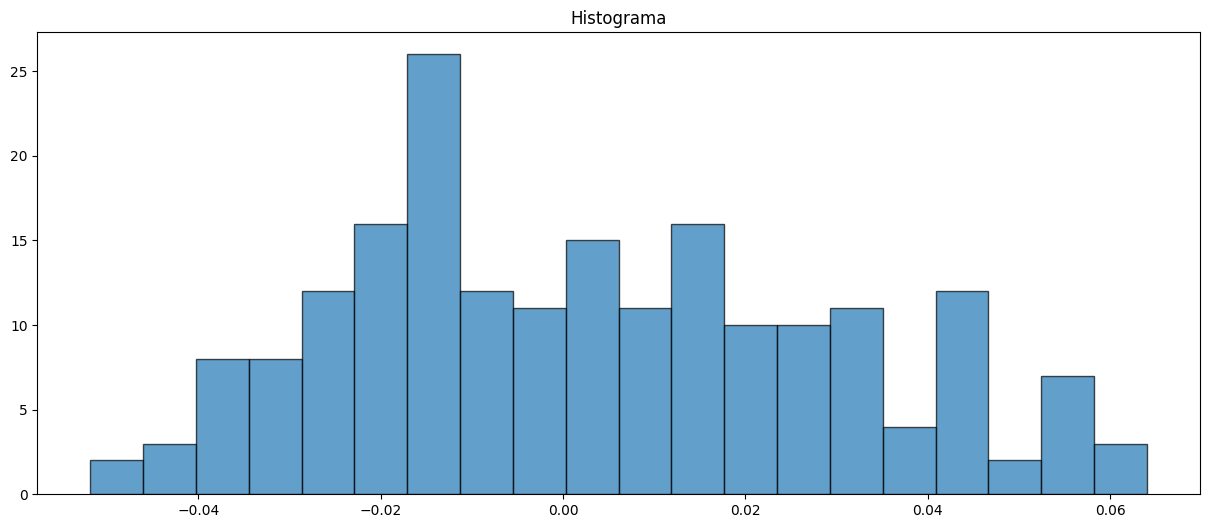

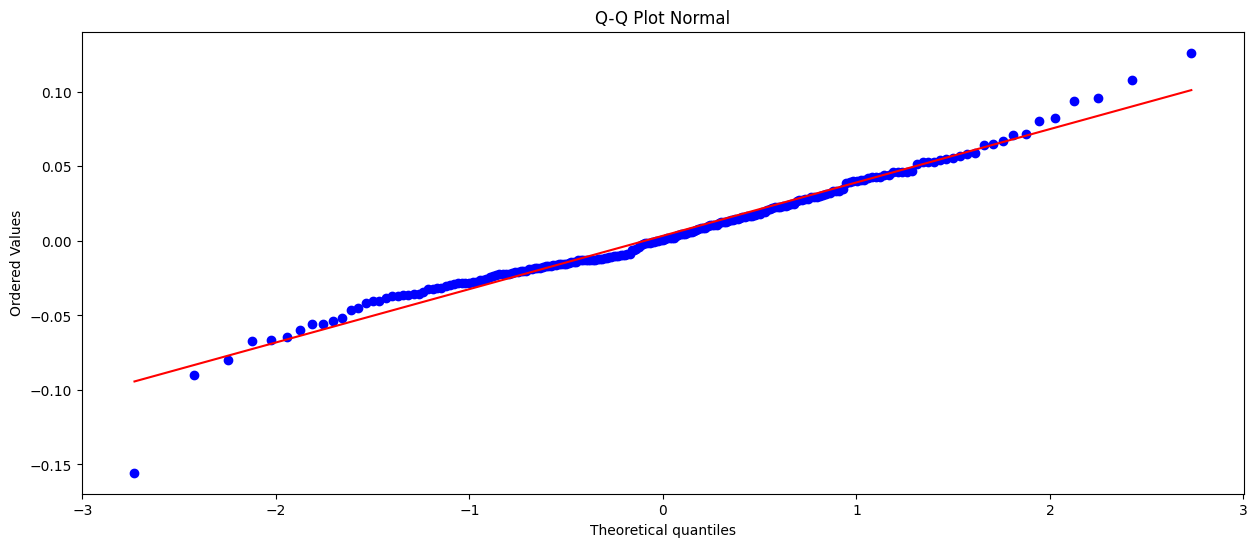

Parâmetros ajustados da normal: μ=0.00, σ=0.04
Estatística do teste KS para normal: 0.0674, p-valor: 0.2602
Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição normal.


Parâmetros ajustados da distribuição t: ν=7.30, μ=0.00, σ=0.03
Estatística do teste KS: 0.0746, p-valor: 0.1660
Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição t.


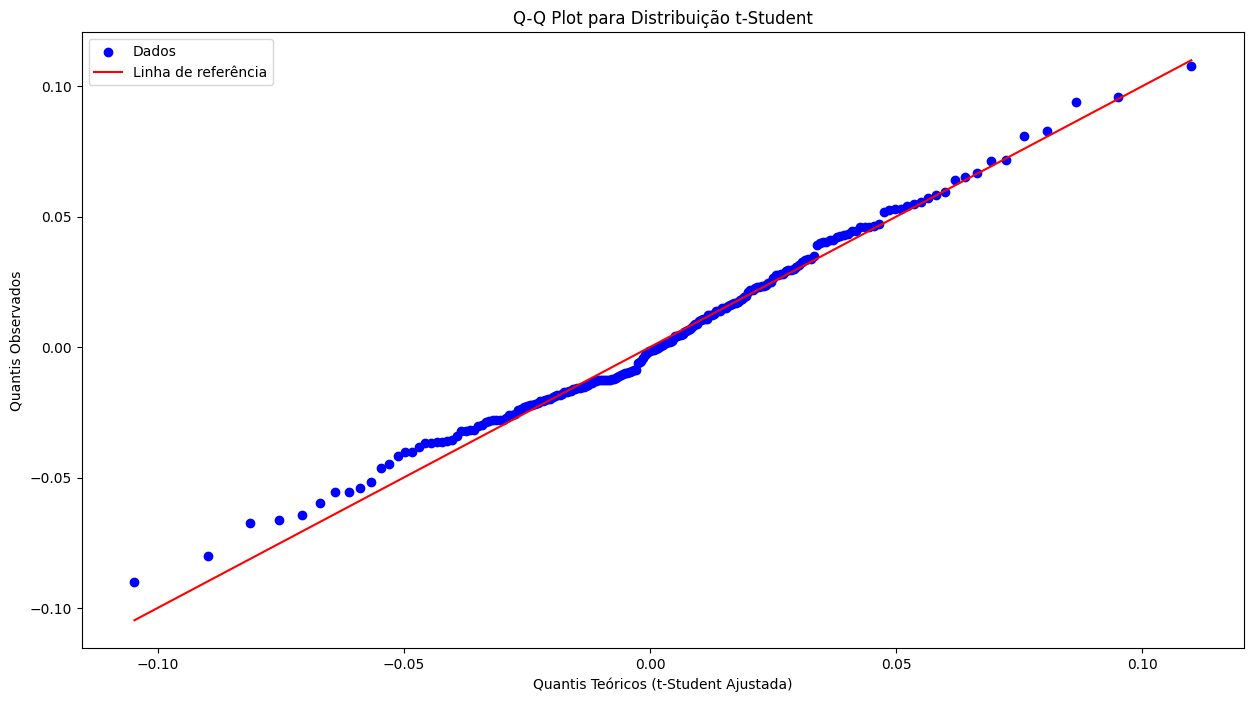

In [5]:
data = dados['Returns']

n_strip = int(len(dados)*0.05)
data_strip = np.sort(dados['Returns'])[n_strip:-n_strip]

# Teste de Shapiro-Wilk
shapiro_test = stats.shapiro(data)
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

# Histograma e Q-Q Plot Normal
plt.figure(figsize=(15, 6))
plt.hist(data_strip, bins=20, edgecolor='k', alpha=0.7)
plt.title('Histograma')
plt.show()

plt.figure(figsize=(15, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot Normal')
plt.show()


# Teste Normal
norm_params = stats.norm.fit(data)
print(f"Parâmetros ajustados da normal: μ={norm_params[0]:.2f}, σ={norm_params[1]:.2f}")

# Teste KS para a normal
ks_stat_norm, p_value_norm = stats.kstest(data, "norm", args=norm_params)
print(f"Estatística do teste KS para normal: {ks_stat_norm:.4f}, p-valor: {p_value_norm:.4f}")

if p_value_norm > 0.05:
    print("Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição normal.\n\n")
else:
    print("Os dados não seguem uma distribuição normal.\n\n")


# Teste t
t_params = stats.t.fit(data)
df, loc, scale = t_params

t_params = stats.t.fit(data)
print(f"Parâmetros ajustados da distribuição t: ν={t_params[0]:.2f}, μ={t_params[1]:.2f}, σ={t_params[2]:.2f}")

# Teste KS comparando os dados à distribuição t ajustada
ks_stat, p_value = stats.kstest(data, "t", args=t_params)
print(f"Estatística do teste KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

if p_value > 0.05:
    print("Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição t.")
else:
    print("Os dados não seguem uma distribuição t.")

# Criar o Q-Q Plot t-student

# Ajustar os parâmetros da distribuição t
t_params = stats.t.fit(data)
df, loc, scale = t_params

# Calcular quantis teóricos e observados
quantiles_theoretical = np.linspace(0, 1, len(data))
quantiles_observed = np.sort(data)
quantiles_t = stats.t.ppf(quantiles_theoretical, df, loc=loc, scale=scale)

# Criar o Q-Q Plot
plt.figure(figsize=(15, 8))
plt.scatter(quantiles_t, quantiles_observed, label="Dados", color="blue")
plt.plot(quantiles_t, quantiles_t, color="red", label="Linha de referência")

plt.title("Q-Q Plot para Distribuição t-Student")
plt.xlabel("Quantis Teóricos (t-Student Ajustada)")
plt.ylabel("Quantis Observados")
plt.legend()
plt.show()


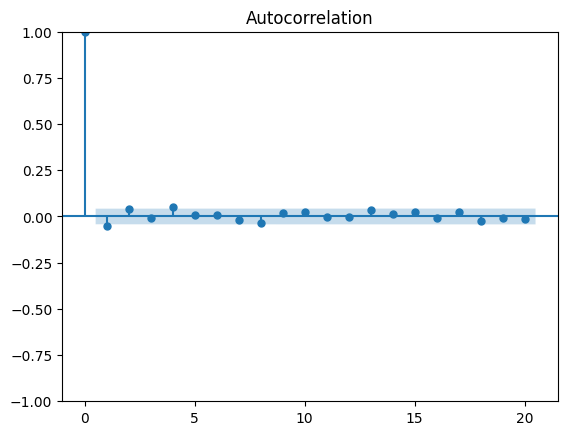

Estatística de Durbin-Watson: 2.1001


      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    5.873148   0.015374   5.864969   0.015445
2    9.832061   0.007328   9.816530   0.007385
3    9.959687   0.018912   9.943859   0.019049
4   15.345671   0.004035  15.314840   0.004091
5   15.560696   0.008217  15.529167   0.008325
6   15.627632   0.015898  15.595854   0.016096
7   16.621506   0.020007  16.585575   0.020273
8   19.487332   0.012460  19.438097   0.012684
9   20.311237   0.016086  20.257794   0.016386
10  21.384078   0.018569  21.324658   0.018940


In [12]:
plot_acf(data, lags=20)
plt.show()

# Teste Durbin-Watson
dw_stat = durbin_watson(data)
print(f"Estatística de Durbin-Watson: {dw_stat:.4f}\n\n")

# Teste Ljung-Box e BoxPierce
box_pierce = acorr_ljungbox(data, lags=10, return_df=True, boxpierce=True)
print(f'{box_pierce}')